# Select GPU if needed

In [1]:
import os
gpu_number = 1
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_number)

# Import modules

In [44]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from model import ssl_maskrcnn
from tools.visualize import save_masks, visualize_image
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale

# Set parameters

In [3]:
weights_file = 'outputs/dinov2_s_final_weights.pt'
dino_model = 'dinov2_s' # Must be configured according to the model of the weights_file
num_classes = 2

# Load weights and define model

In [4]:
model = ssl_maskrcnn(num_classes, dino_model)
weights = torch.load(weights_file, weights_only=True)
model.load_state_dict(weights)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Using cache found in /home/wormhole/.cache/torch/hub/facebookresearch_dinov2_main
/home/wormhole/.conda/envs/dfuc/lib/python3.8/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/wormhole/.conda/envs/dfuc/lib/python3.8/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/home/wormhole/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/wormhole/.cache/torch/hub/facebookr

# Set transform

In [109]:
img_height = 14*64
img_width = 14*64
img_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)), # multiple of patch_size(=14)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Visualize

In [6]:
v_image = 'data/valid/image/100049.jpg'
v_mask = 'data/valid/mask/100049.png'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


scores= tensor([1.0000], device='cuda:0')


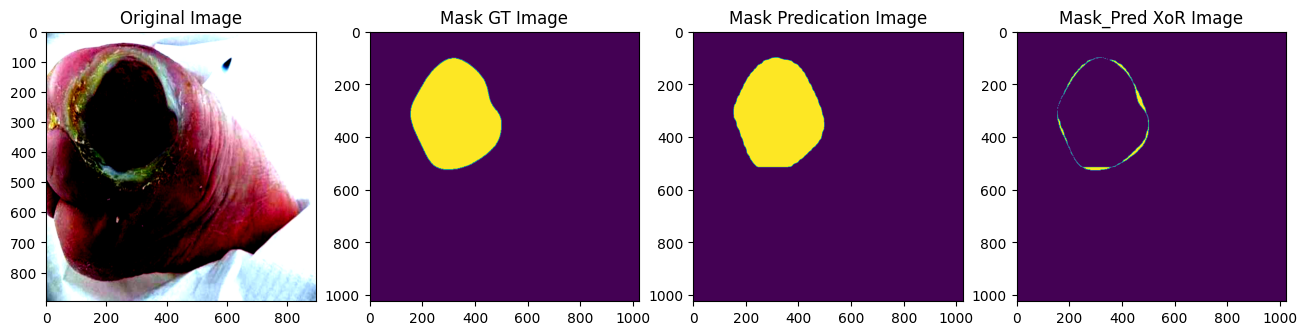

In [7]:
visualize_image(model, v_image, v_mask, img_transform=img_transform)

# PCA components of the feature extracted from the Dinov2 backbone

n_comp= 0


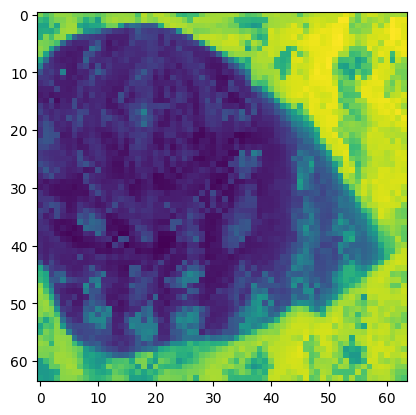

n_comp= 1


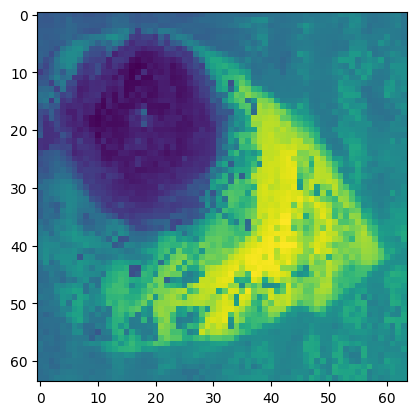

n_comp= 2


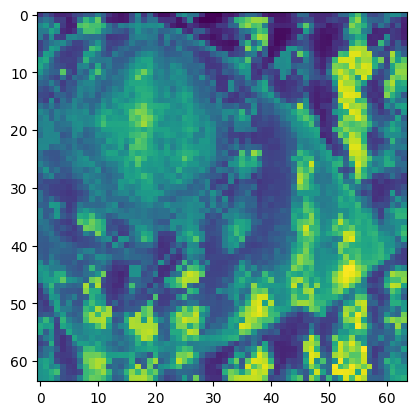

In [121]:
img = Image.open(v_image).convert('RGB')
img_t = img_transform(img)
features_dict = model.backbone.forward_features(img_t.unsqueeze(0).to(device))
features = features_dict['x_norm_patchtokens']
feat_dim = features.shape[-1]
features = features.reshape(-1, feat_dim) #4(*H*w, 1024)

n_comp = 3
pca = PCA(n_components=n_comp)
pca.fit(features.cpu().detach().numpy())
pca_features = pca.transform(features.cpu().detach().numpy())
pca_features = minmax_scale(pca_features)

pca_w = int(img_width/14)
pca_h = int(img_height/14)

for n in range(n_comp):
    print('n_comp=', n)
    plt.imshow(pca_features[:, n].reshape(pca_h, pca_w))
    plt.show()